Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту.

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import math

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import norm
from scipy import stats
from statsmodels.stats.weightstats import zconfint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

**Загрузка данных**

In [2]:
df_train = pd.read_csv('course_project_train.csv')
df_test = pd.read_csv('course_project_test.csv')
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [3]:
df_train.columns = ['_'.join(col.split(' ')).lower() for col in df_train.columns]
df_test.columns = ['_'.join(col.split(' ')).lower() for col in df_test.columns]
TARGET = 'credit_default'

In [4]:
df_train.head()

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,credit_default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                7500 non-null   object 
 1   annual_income                 5943 non-null   float64
 2   years_in_current_job          7129 non-null   object 
 3   tax_liens                     7500 non-null   float64
 4   number_of_open_accounts       7500 non-null   float64
 5   years_of_credit_history       7500 non-null   float64
 6   maximum_open_credit           7500 non-null   float64
 7   number_of_credit_problems     7500 non-null   float64
 8   months_since_last_delinquent  3419 non-null   float64
 9   bankruptcies                  7486 non-null   float64
 10  purpose                       7500 non-null   object 
 11  term                          7500 non-null   object 
 12  current_loan_amount           7500 non-null   float64
 13  cur

Функция для поиска количества пропущенных зачений и какой процент составляют пропуски от общего количества наблюдений

In [6]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
missing_values = missing_values_table(df_train)
missing_values.head()

Your selected dataframe has 17 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
months_since_last_delinquent,4081,54.4
annual_income,1557,20.8
credit_score,1557,20.8
years_in_current_job,371,4.9
bankruptcies,14,0.2


In [8]:
missing_values = missing_values_table(df_test)
missing_values.head()

Your selected dataframe has 16 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
months_since_last_delinquent,1358,54.3
annual_income,513,20.5
credit_score,513,20.5
years_in_current_job,86,3.4
bankruptcies,3,0.1


Меняем значения переменной 'years_in_current_job' на целочисленные значения 

In [9]:
years_dict = {'-1': -1, '10+ years': 10, '8 years': 8, '6 years': 6, 
              '7 years': 7, '5 years': 5, '1 year': 1, '< 1 year': 0, 
              '4 years': 4, '3 years': 3, '2 years': 2, '9 years': 9}

df_train['years_in_current_job'] = (df_train['years_in_current_job']
                                .fillna('-1')
                                .map(years_dict))

df_test['years_in_current_job'] = (df_test['years_in_current_job']
                                .fillna('-1')
                                .map(years_dict))

In [10]:
df_test['years_in_current_job'].value_counts(dropna=False)

 10    810
 3     228
 2     212
 0     207
 5     169
 1     153
 4     152
 7     140
 6     137
 8     107
 9      99
-1      86
Name: years_in_current_job, dtype: int64

### Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

**Обзор распределения**

In [11]:
df_train[TARGET].value_counts()

0    5387
1    2113
Name: credit_default, dtype: int64

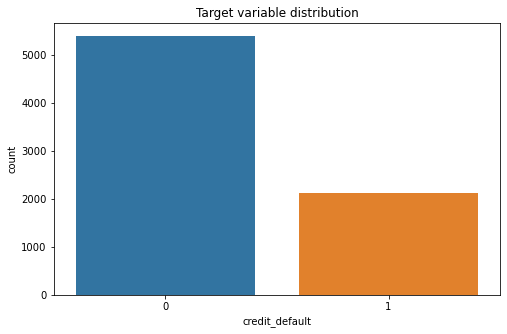

In [12]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET, data=df_train)

plt.title('Target variable distribution')
plt.show()

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                7500 non-null   object 
 1   annual_income                 5943 non-null   float64
 2   years_in_current_job          7500 non-null   int64  
 3   tax_liens                     7500 non-null   float64
 4   number_of_open_accounts       7500 non-null   float64
 5   years_of_credit_history       7500 non-null   float64
 6   maximum_open_credit           7500 non-null   float64
 7   number_of_credit_problems     7500 non-null   float64
 8   months_since_last_delinquent  3419 non-null   float64
 9   bankruptcies                  7486 non-null   float64
 10  purpose                       7500 non-null   object 
 11  term                          7500 non-null   object 
 12  current_loan_amount           7500 non-null   float64
 13  cur

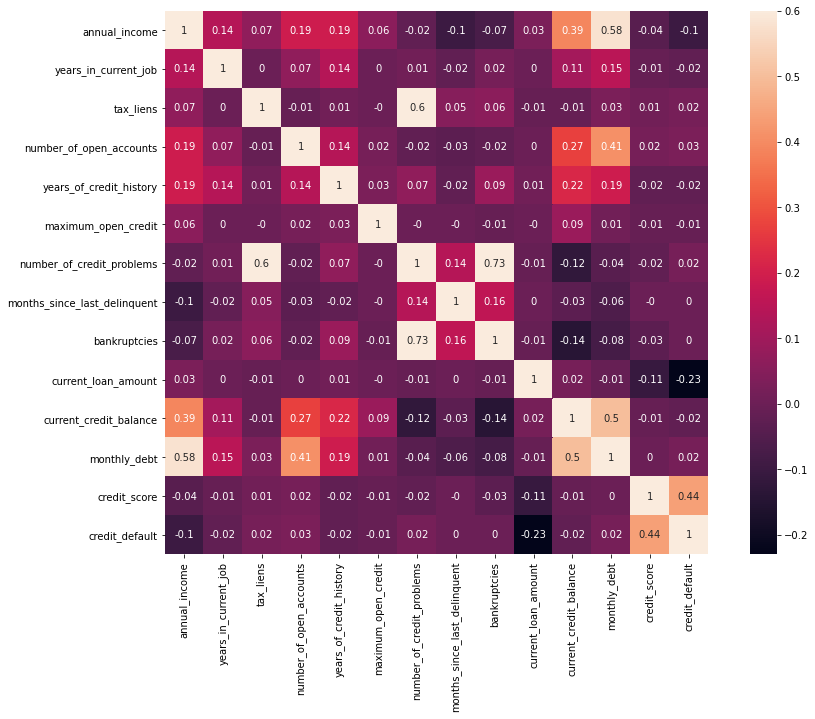

In [14]:
corrmat = df_train.loc[:, df_train.columns].corr().round(2)
plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=0.6, square=True, annot=True)

In [15]:
FEATURES = list(df_train.drop([TARGET], axis=1))
NUM_FEATURES = list(df_train[FEATURES].select_dtypes(include='number'))

Функция для заполнения пропущенных значений в переменных 'years_in_current_job', 'months_since_last_delinquent', 'bankruptcies'

In [16]:
def missing_values_clean(df):
    
    if pd.api.types.is_categorical_dtype(df['years_in_current_job']):
        df['years_in_current_job'] = df['years_in_current_job'].cat.add_categories(['0'])
    
    df['years_in_current_job'] = df['years_in_current_job'].fillna('0')

    df['months_since_last_delinquent'] = df['months_since_last_delinquent'].fillna(0)

    df['bankruptcies'] = df['bankruptcies'].fillna(0)
    
    return df

In [17]:
df_train = missing_values_clean(df_train)
df_test = missing_values_clean(df_test)

In [18]:
missing_values = missing_values_table(df_train)
missing_values.head()

Your selected dataframe has 17 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
annual_income,1557,20.8
credit_score,1557,20.8


In [19]:
missing_values = missing_values_table(df_test)
missing_values.head()

Your selected dataframe has 16 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
annual_income,513,20.5
credit_score,513,20.5


In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                7500 non-null   object 
 1   annual_income                 5943 non-null   float64
 2   years_in_current_job          7500 non-null   int64  
 3   tax_liens                     7500 non-null   float64
 4   number_of_open_accounts       7500 non-null   float64
 5   years_of_credit_history       7500 non-null   float64
 6   maximum_open_credit           7500 non-null   float64
 7   number_of_credit_problems     7500 non-null   float64
 8   months_since_last_delinquent  7500 non-null   float64
 9   bankruptcies                  7500 non-null   float64
 10  purpose                       7500 non-null   object 
 11  term                          7500 non-null   object 
 12  current_loan_amount           7500 non-null   float64
 13  cur

С помощью кодировщика меняю тип ряда категориальных переменных в числовой

In [21]:
le = LabelEncoder()

In [22]:
df_train['home_ownership']= le.fit_transform(df_train['home_ownership'])
df_test['home_ownership']= le.fit_transform(df_test['home_ownership']) 

df_train['purpose']= le.fit_transform(df_train['purpose'])
df_test['purpose']= le.fit_transform(df_test['purpose']) 

df_train['term']= le.fit_transform(df_train['term'])
df_test['term']= le.fit_transform(df_test['term'])

### Нормализация данных<a class="anchor" id="normalization"></a>

In [23]:
scaler = StandardScaler()

In [24]:
df_norm = df_train.copy()
df_norm[NUM_FEATURES] = scaler.fit_transform(df_norm[NUM_FEATURES])
df_train = df_norm.copy()

In [25]:
df_norm = df_test.copy()
df_norm[NUM_FEATURES] = scaler.transform(df_norm[NUM_FEATURES])
df_test = df_norm.copy()

Пропуски в переменных 'annual_income' и 'credit_score' заменяю на значение (-999)

In [26]:
#df_train['annual_income'] = df_train['annual_income'].fillna(-999)
#df_test['annual_income'] = df_test['annual_income'].fillna(-999)
df_train['annual_income'].fillna(df_train['annual_income'].mean(), inplace=True)
df_test['annual_income'].fillna(df_train['annual_income'].mean(), inplace=True)

In [27]:
#df_train['credit_score'] = df_train['credit_score'].fillna(-999)
#df_test['credit_score'] = df_test['credit_score'].fillna(-999)
df_train['credit_score'].fillna(df_train['credit_score'].median(), inplace=True)
df_test['credit_score'].fillna(df_train['credit_score'].median(), inplace=True)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [28]:
X = df_train[FEATURES]
y = df_train[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [29]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.values.argmax()
    minor_class_name = target_counts.values.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [30]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET)
    
df_balanced[TARGET].value_counts()
X_train = df_balanced.drop(columns=TARGET)
y_train = df_balanced[TARGET]

In [31]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [32]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [33]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)


TRAIN

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      3771
           1       0.71      0.49      0.58      2958

    accuracy                           0.69      6729
   macro avg       0.69      0.67      0.67      6729
weighted avg       0.69      0.69      0.68      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.54      0.50      0.51       634

    accuracy                           0.74      2250
   macro avg       0.67      0.66      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1344  272
1                320  314


**k ближайших соседей**

In [34]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      3771
           1       0.79      0.71      0.75      2958

    accuracy                           0.79      6729
   macro avg       0.79      0.78      0.78      6729
weighted avg       0.79      0.79      0.79      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1616
           1       0.43      0.49      0.46       634

    accuracy                           0.68      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.69      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1213  403
1                324  310


**Бустинговые алгоритмы**

*XGBoost*

In [35]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3771
           1       0.99      0.98      0.98      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1616
           1       0.52      0.44      0.48       634

    accuracy                           0.73      2250
   macro avg       0.65      0.64      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1351  265
1                352  282


*LightGBM*

In [36]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3771
           1       0.95      0.88      0.91      2958

    accuracy                           0.93      6729
   macro avg       0.93      0.92      0.93      6729
weighted avg       0.93      0.93      0.93      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1616
           1       0.52      0.46      0.48       634

    accuracy                           0.73      2250
   macro avg       0.66      0.64      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1345  271
1                345  289


*CatBoost*

In [37]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3771
           1       0.94      0.86      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.92      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1616
           1       0.54      0.46      0.50       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1369  247
1                341  293


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [38]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

**Подбор гиперпараметров**

In [39]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [40]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [41]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 3min 30s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002D9698B9400>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [42]:
rs.best_params_

{'n_estimators': 1200, 'max_depth': 3}

In [43]:
rs.best_score_

0.5458966364834983

**Обучение и оценка финальной модели**

In [44]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1200, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      3771
           1       0.80      0.65      0.71      2958

    accuracy                           0.77      6729
   macro avg       0.78      0.76      0.76      6729
weighted avg       0.77      0.77      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.54      0.50      0.51       634

    accuracy                           0.74      2250
   macro avg       0.67      0.66      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1344  272
1                320  314
Wall time: 10.1 s


### Финальная модель<a class="anchor" id="final_model"></a>

In [45]:
y_pred_test = final_model.predict(
    df_test[FEATURES]
)

In [46]:
df_test[TARGET] = y_pred_test

In [47]:
df_test[['credit_default']].to_csv('VBogdanova_predictions.csv', index=None)

In [48]:
df_test[['credit_default']]

,credit_default
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,0
2497,1
2498,0


In [49]:
df_predict = pd.read_csv('VBogdanova_predictions.csv')

In [50]:
df_predict.shape

(2500, 1)